# Coding Attention Mechanisms

Attention mechanisms allows the model to focus on the more important parts.

This is a roadmap of how thiw will be.
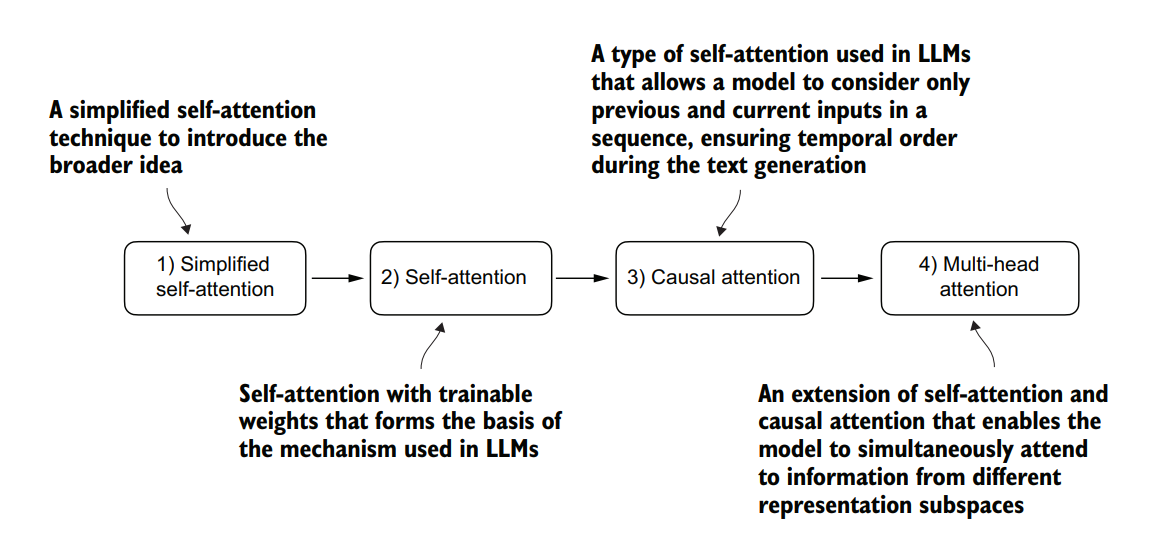

Focus attention mechanisms are important as we cant simply translate elements word by word due to grammatical structures. 

Moreover, if we wanted to predict the cat is playing, it is fierce, when predicting it, we should focus on the fact we are dealing with a cat.

For the previously mentioned statementes, it is immportant to implement this mechanisms.

 We will start with a simple mechanism and start working from there

 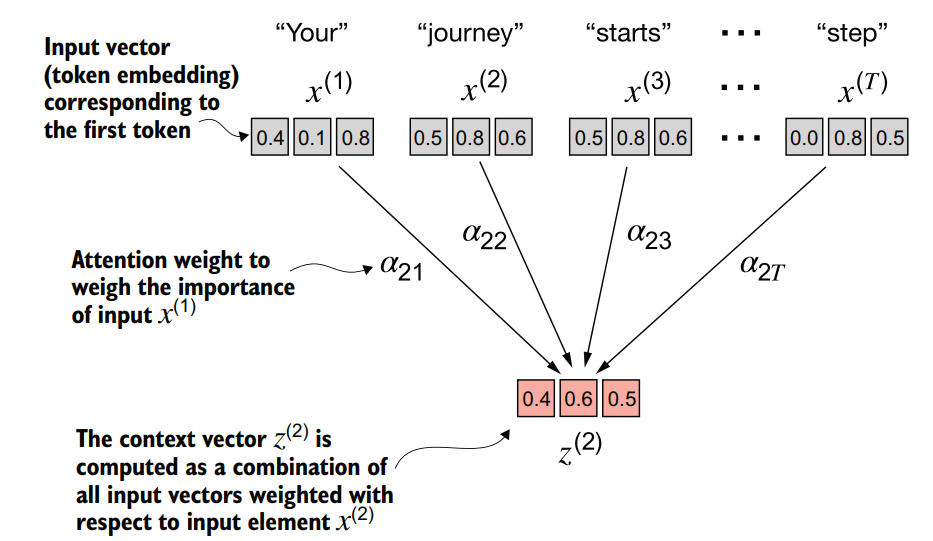

The importance of each input is determined by the attention weights.

We want to obtain a context vector for each element in the input.

In [3]:
# Making a short example
import torch
inputs = torch.tensor(
 [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6)
)

# Attention scores are computed with the dot product
# As we are calculating the context vector for the second element, we use the second element for the dot product.

query = inputs[1] 
attn_scores_2 = torch.empty(inputs.shape[0]) # Creates a 1D empty tensor to store results
for i, x_i in enumerate(inputs):
 attn_scores_2[i] = torch.dot(x_i, query) # Dot prodcuts
print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


The dot product is used as a higher value provides a higher similarity as well.

Methods such as softmax are used to handle extreme values and to provide normalization.

Softmax provide positive values and higher values indicate a greater importance.

In [4]:
def softmax_naive(x):
 return torch.exp(x) / torch.exp(x).sum(dim=0)


attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


To calculate the context vector, each of the tokens is multiplied with their corresponding attention weights which are then summed into the resulting vectors.

We will now compute the attention weights for all input tokens simultaneously.

In [8]:

attn_scores = torch.empty(6, 6) # Empty 6x6 matrix
for i, x_i in enumerate(inputs):
 for j, x_j in enumerate(inputs):
    attn_scores[i, j] = torch.dot(x_i, x_j)
print("For loop results: ", attn_scores)

# For efficiency, instead of for loops we will use matrix multiplications
attn_scores = inputs @ inputs.T
print("Matrix multiplication results. ", attn_scores)

# Normalizing the scores
attn_weights = torch.softmax(attn_scores, dim = -1) # Dim specifies the dimension along which the function will be applied on   
print("Normalized weights: ", attn_weights)

# Obtaining context vectors
all_context_vecs = attn_weights @ inputs
print("Context vectors: ",all_context_vecs)

For loop results:  tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Matrix multiplication results.  tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
Normalized weights:  tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720]

Implementing self-attention with trainable weights.